<a href="https://colab.research.google.com/github/moshekranc-git/pythonplayground/blob/master/SpeechRecognition1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Install all needed python libraries

In [0]:

!pip install SpeechRecognition
!pip install pydub
!pip install moviepy
!pip install google_cloud
!pip install google-cloud-speech
#!pip install wheel


/content


#2. Upload the video file to be analyzed into the colab environment


###2A. For small files (< 1 minute):


In [0]:
# for test purposes, start with a small test file until you are sure everything works
!gsutil cp gs://cloud-samples-tests/speech/brooklyn.flac brooklyn.flac 
  

Copying gs://cloud-samples-tests/speech/brooklyn.flac...
/ [1 files][ 32.7 KiB/ 32.7 KiB]                                                
Operation completed over 1 objects/32.7 KiB.                                     


###2B. For large files (> 1 minute)

To download a file from YouTube to your local mac machine, use ClipGrab. See https://www.wikihow.com/Download-YouTube-Videos-on-a-Mac

To upload the video file from your local machine to colab: Click on the folder icon on the left, then use the interface to upload the file. (Remember: you will need to upload the file each time you reinstantiate colab.)

For this notebook, I will be using "Alphabet 2019 Q3 Earnings Call.mp4" which can be found at https://www.youtube.com/watch?v=1vj7AjthgjE

#3. Extract the sound from the video file in a format that the speech recognition library can understand.
Most speech recognition libraries require a lossless codec to transmit audio. FLAC or LINEAR16 is recommended.

###3A. For small files

do nothing - the test file is already in FLAC format

###3B. For large files

Use ffmpeg directly

In [21]:
!ffmpeg -i "Alphabet 2019 Q3 Earnings Call.mp4" -ac 1 "Alphabet 2019 Q3 Earnings Call.flac"


ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

Just to be sure, download to my machine and listen to make sure it worked

In [0]:
from google.colab import files
files.download("Alphabet 2019 Q3 Earnings Call.flac")

Upload FLAC file to Google Cloud Storage - the only way Google will process large files

In [22]:
# First you need to authenticate CoLab to your Google account with:
from google.colab import auth
auth.authenticate_user()

# Once this is done you need to set your project and bucket name and then update the gcloud config.
project_id = 'Moshe1'
bucket_name = 'moshe_bucket'
!gcloud config set project moshe1

#After this has been done files can simply and quickly be upload or downloaded from the bucket with the following simple commands:
!gsutil cp  ./Alphabet\ 2019\ Q3\ Earnings\ Call.flac gs://moshe_bucket/Alphabet\ 2019\ Q3\ Earnings\ Call.flac

Updated property [core/project].
Copying file://./Alphabet 2019 Q3 Earnings Call.flac [Content-Type=audio/flac]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/201.8 MiB.                                    


#4. Convert speech to text
See:

https://stackabuse.com/introduction-to-speech-recognition-with-python/ 

https://becominghuman.ai/the-ultimate-guide-to-speech-recognition-with-python-d45256c73e54


https://github.com/Uberi/speech_recognition/blob/master/reference/library-reference.rst

https://springml.com/blog/text-classification-natural-language-api/



###4A. For small files

In [0]:
import requests
import io
import speech_recognition as sr
import json

# This function translate speech to text
def speech_to_text(file):
  recognizer = sr.Recognizer()
  audio = sr.AudioFile(file)
  with audio as source:
    speech = recognizer.record(source)
    try:
      # Call recognizer with audio 
      text = recognizer.recognize_google (speech)
      return text
    # If recognizer doesn't understand
    except sr.UnknownValueError: 
      print("Speech Recognition service could not understand audio") 
    except sr.RequestError as e: 
      print("Could not request results from Speech Recognition service; {0}".format(e)) 

text = speech_to_text("brooklyn.flac")
print(text)

how old is the Brooklyn Bridge


###4B. For large files


This requires a paying account on Google - the free versions will not handle long audio. After creating an account and creating credentials, upload the json credentials file to colab, then pass the file name as a parameter to recognize_google_cloud

(An alternative would be to chunk the large audio file into smaller chunks - see https://www.geeksforgeeks.org/python-speech-recognition-on-large-audio-files/)

In [23]:
import requests
import io
import os
import json
from google.cloud import speech_v1
from google.cloud.speech_v1 import enums
from google.cloud import storage


# This function translate speech to text
def speech_to_text(uri):
    # Set credentials via environment variable
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/moshe1-aaae31fcbe39.json" 

    client = speech_v1.SpeechClient()

    # The language of the supplied audio
    language_code = "en-US"

    # Encoding of audio data sent. This sample sets this explicitly.
    # This field is optional for FLAC and WAV audio formats.
    encoding = enums.RecognitionConfig.AudioEncoding.FLAC
    config = {
        "language_code": language_code,
        "encoding": encoding,
        "audio_channel_count": 1,
    }
    audio = {"uri": uri}

    operation = client.long_running_recognize(config, audio)

    print(u"Waiting for operation to complete...")
    # should show a progress bar!

    response = operation.result()
    print(response)
    return response

raw_text = speech_to_text('gs://moshe_bucket/Alphabet 2019 Q3 Earnings Call.flac')


Waiting for operation to complete...
results {
  alternatives {
    transcript: "ladies and gentlemen thank you for standing by and welcome to the alphabet third quarter 2019 earnings call at this time all participants lines are in a listen-only mode after the speaker\'s presentation there will be a question-and-answer session to ask a question during the session you will need to press star and then one on your telephone if you require any further assistance please press start and then 0 I know I think I\'m the conference over to your speaker today Ellen west side of investor relations please go ahead thank you good afternoon everyone and welcome to alphabets third quarter 2019 earnings conference call with us today our Sundar pichai and Ruth porat Now quickly cover the Safe Harbor some of the statements that we make today regarding our business performance in operations and are expected level of capital expenditures may be considered forward-looking and such statements involve a numbe

In [25]:
# gather together the transciption chunks into a single string
text = ''
for res in raw_text.results:
    alt = res.alternatives[0]
    text += alt.transcript

print(text)

ladies and gentlemen thank you for standing by and welcome to the alphabet third quarter 2019 earnings call at this time all participants lines are in a listen-only mode after the speaker's presentation there will be a question-and-answer session to ask a question during the session you will need to press star and then one on your telephone if you require any further assistance please press start and then 0 I know I think I'm the conference over to your speaker today Ellen west side of investor relations please go ahead thank you good afternoon everyone and welcome to alphabets third quarter 2019 earnings conference call with us today our Sundar pichai and Ruth porat Now quickly cover the Safe Harbor some of the statements that we make today regarding our business performance in operations and are expected level of capital expenditures may be considered forward-looking and such statements involve a number of risks and uncertainties that could cause actual results to differ materiallyfo

#5. Save text to a file for subsequent processing

In [0]:
#save the returned text to a file
text_file = open("speech.txt", "w")
n = text_file.write(text)
text_file.close()


#6. Read text from file

In [0]:
text_file = open("speech.txt", "r")
text = text_file.read();
text_file.close();

#7. Create a tag cloud

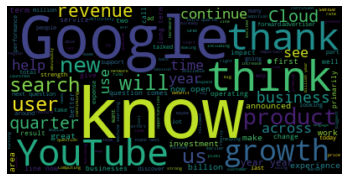

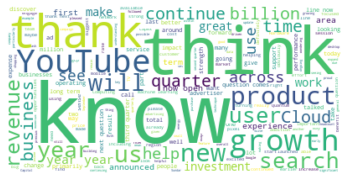

In [27]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#Alternate display

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Alphabet", "Google"])

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#8. Frequency Distribution

#9. Sentiment Analysis

#10. Finding N-Grams

#11. Keyword Extraction

#12. Twitter Feeds